# Northwind Regression Modeling

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer

from feature_engine.outliers import Winsorizer

set_config(transform_output='pandas')

In [3]:
data = './data/Order Details.csv'

df_data = pd.read_csv(data)

df_data

,OrderID,ProductID,UnitPrice,Quantity,Discount
0,10248,11,14.00,12,0.00
1,10248,42,9.80,10,0.00
2,10248,72,34.80,5,0.00
3,10249,14,18.60,9,0.00
4,10249,51,42.40,40,0.00
...,...,...,...,...,...
2150,11077,64,33.25,2,0.03
2151,11077,66,17.00,1,0.00
2152,11077,73,15.00,2,0.01
2153,11077,75,7.75,4,0.00


In [83]:
X = df_data.drop(columns=['UnitPrice', 'OrderID'])
y = df_data['UnitPrice']

In [79]:
X

,Quantity,Discount
0,12,0.00
1,10,0.00
2,5,0.00
3,9,0.00
4,40,0.00
...,...,...
2150,2,0.03
2151,1,0.00
2152,2,0.01
2153,4,0.00


In [80]:
cat_features = ['ProductID']
num_features = ['Quantity', 'Discount']

cat_features, num_features

(['ProductID'], ['Quantity', 'Discount'])

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
cat_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',
                             sparse_output=False,
                             max_categories=10))
])

num_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[('num', num_preprocessor, num_features),
                                               ('cat', cat_preprocessor, cat_features)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor())])

model.fit(X, y)

cv_score = cross_val_score(model, X, y)

print(f'CV score: {cv_score.mean():.2f} +/- {cv_score.std():.2f}')

ValueError: A given column is not a column of the dataframe

In [72]:
cat_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',
                             sparse_output=False))
])

num_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', Winsorizer(capping_method='iqr', tail='both', fold=1.5)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[('num', num_preprocessor, num_features),
                                               ('cat', cat_preprocessor, cat_features)])

regressor = RandomForestRegressor()

transformed_regressor = TransformedTargetRegressor(regressor=regressor,
                                                   transformer=PowerTransformer())

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', transformed_regressor)])


cv_score = cross_val_score(model, X, y)

print(f'CV score: {cv_score.mean():.2f} +/- {cv_score.std():.2f}')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


CV score: 0.96 +/- 0.02


In [73]:
model.fit(X_train, y_train)

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5,
                                                                              tail='both')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Quantity', 'Discount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['ProductID'])])),
                ('regressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                            transformer=PowerTransformer()))])

In [74]:
permutation_importance(model, X_train, y_train)

{'importances_mean': array([1.95396007, 0.01185995, 0.00612116]),
 'importances_std': array([0.02108773, 0.00192177, 0.00065715]),
 'importances': array([[1.94037263, 1.97209274, 1.97733669, 1.95966849, 1.92032978],
        [0.01388803, 0.01132378, 0.0130262 , 0.00838932, 0.01267241],
        [0.00561334, 0.00515053, 0.00692337, 0.00625066, 0.00666789]])}

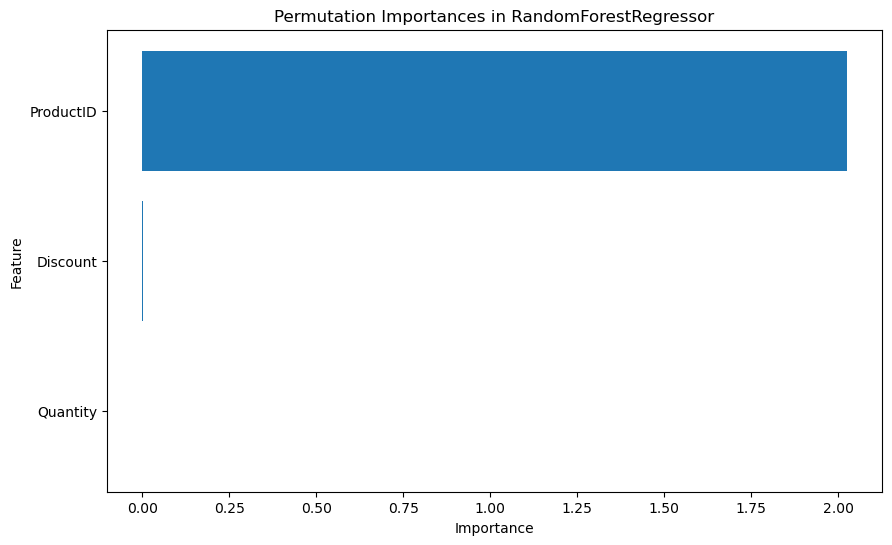

In [77]:
# Calculate permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Visualize permutation importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances in RandomForestRegressor')
plt.gca().invert_yaxis()
plt.show()

In [31]:
cat_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', Winsorizer(capping_method='iqr', tail='both', fold=1.5)),
    ('scaler', PowerTransformer())
])

preprocessor = ColumnTransformer(transformers=[('num', num_preprocessor, num_features),
                                               ('cat', cat_preprocessor, cat_features)])

regressor = Ridge()

transformed_regressor = TransformedTargetRegressor(regressor=regressor,
                                                   transformer=PowerTransformer())

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', transformed_regressor)])

model.fit(X, y)

cv_score = cross_val_score(model, X, y)

print(f'CV score: {cv_score.mean():.2f} +/- {cv_score.std():.2f}')

CV score: 0.96 +/- 0.01


c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has featur

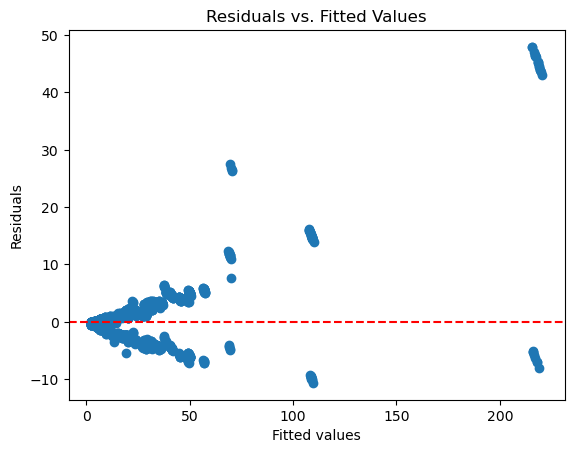

In [38]:
y_pred = model.predict(X)
residuals = y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

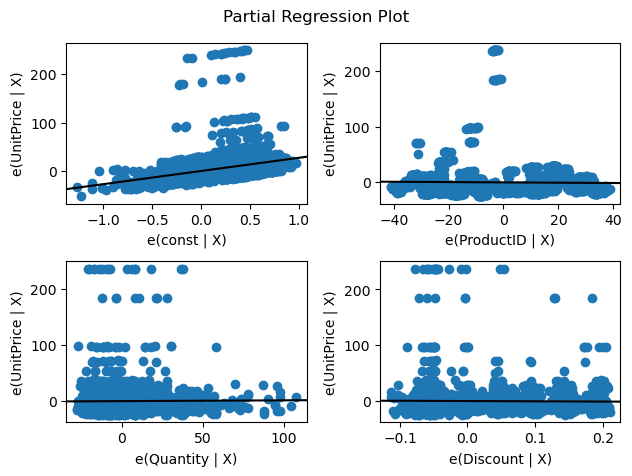

In [39]:
import statsmodels.api as sm

# Assuming X is a DataFrame
X_train_sm = sm.add_constant(X)
ridge_model_sm = sm.OLS(y, X_train_sm).fit()

fig = sm.graphics.plot_partregress_grid(ridge_model_sm)
fig.tight_layout(pad=1.0)
plt.show()

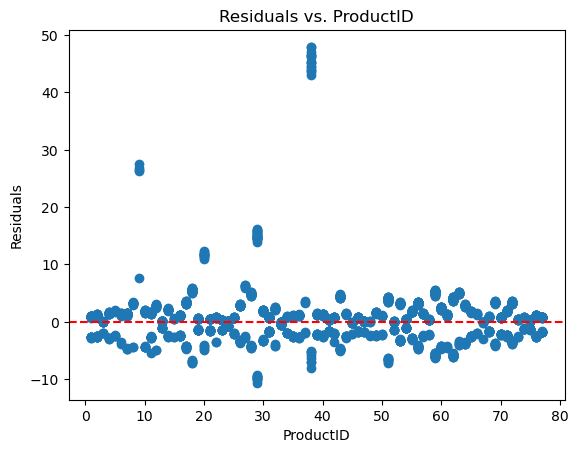

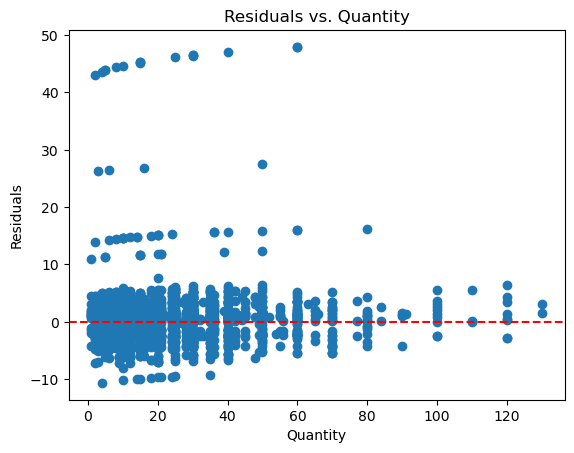

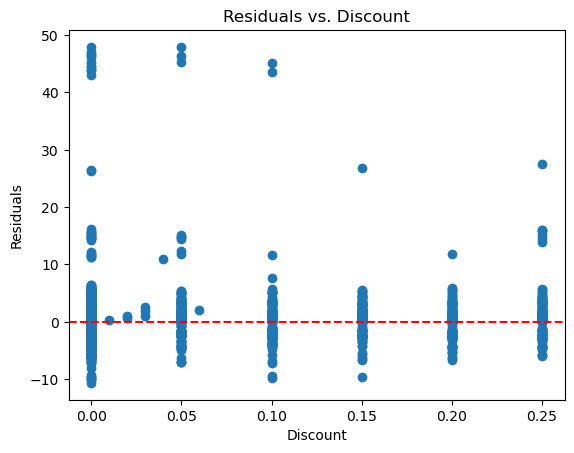

In [42]:
for i, col in enumerate(X.columns):
    plt.figure(i)
    plt.scatter(X[col], residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(col)
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. {col}')
    plt.show()